<a href="https://colab.research.google.com/github/vkchadha/cs634_assignment3/blob/main/cs634_assignment3_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.12.0
Found GPU at: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
class_names

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

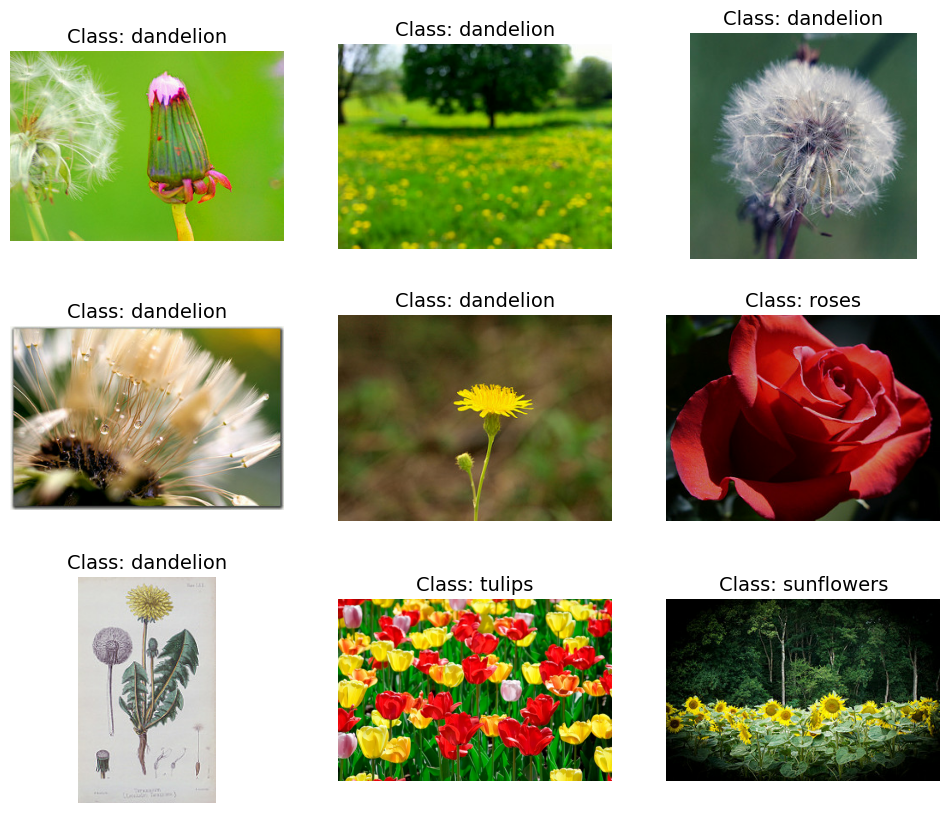

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 33s 217ms/step - loss: 0.8358 - accuracy: 0.7983 - val_loss: 0.7826 - val_accuracy: 0.8367
Epoch 2/3
86/86 [==============================] - 16s 177ms/step - loss: 0.3434 - accuracy: 0.9132 - val_loss: 0.5976 - val_accuracy: 0.8457
Epoch 3/3
86/86 [==============================] - 16s 178ms/step - loss: 0.1844 - accuracy: 0.9379 - val_loss: 0.7546 - val_accuracy: 0.8421


In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 42s 340ms/step - loss: 0.2857 - accuracy: 0.9128 - val_loss: 0.4781 - val_accuracy: 0.8766
Epoch 2/10
86/86 [==============================] - 30s 340ms/step - loss: 0.0375 - accuracy: 0.9873 - val_loss: 0.3965 - val_accuracy: 0.9056
Epoch 3/10
86/86 [==============================] - 29s 323ms/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.3720 - val_accuracy: 0.9056
Epoch 4/10
86/86 [==============================] - 30s 340ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.4912 - val_accuracy: 0.8784
Epoch 5/10
86/86 [==============================] - 29s 325ms/step - loss: 0.0394 - accuracy: 0.9884 - val_loss: 0.3491 - val_accuracy: 0.9056
Epoch 6/10
86/86 [==============================] - 29s 326ms/step - loss: 0.0069 - accuracy: 0.9971 - val_loss: 0.3421 - val_accuracy: 0.9111
Epoch 7/10
86/86 [==============================] - 29s 332ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 0.3720 - val_accuracy: 0.9165

-----
Transfer Learning vs Non Transfer Learning.  

In the this case , we took a standard imagenet model.
We took a tf_flowers data set & used a model which was not trained to run against validation data set. ( Basically kept the weigths the same ) Best we got is a 84.6 % accuracy .
But when we trained the  model , we started to a accuracy of close to 92%